# Section 4: Statistical Models

In Section 4, you will look at statistical models in the context of election polling and forecasting.

After completing Section 4, you will be able to:

- Understand how aggregating data from different sources, as poll aggregators do for poll data, can improve the precision of a prediction.
- Understand how to fit a multilevel model to the data to forecast, for example, election results.
- Explain why a simple aggregation of data is insufficient to combine results because of factors such as pollster bias.
- Use a data-driven model to account for additional types of sampling variability such as pollster-to-pollster variability.

There is 1 assignment that uses the DataCamp platform for you to practice your coding skills.

We encourage you to use R to interactively test out your answers and further your learning.

In [87]:
using Distributions
using StatsBase
using DataFrames
using RDatasets
using Dates
using StatsPlots
using Plots

We start by defining the usual functions from R: `pnorm` and `qnorm`.

In [2]:
# Define the pnorm from R.
pnorm(x::Number) = cdf(Normal(0, 1), x);
# Define the qnorm from R.
qnorm(x::Number) = quantile(Normal(0, 1), x);

## Poll Aggregators

### Defining the functions to compute the Monte Carlo simulation to generate the data

We use a multiple dispatch approach to create the data related to confidence intervals.

We start by creating a function which receives a value $N$ from a vector of integers and a value of probability $p$.

Next we create the same function but now it will receive the whole vector of values $N_s$ and will do the computing using a MapReduce approach to concatenate all the results from evaluating the whole vector $N_s$ and transpose the matrix so we can create a table to elements $\#N_s$

Finally we use the previous function to generate 3 data frames. One which will have the row number of the data, the data, and the sample sizes. We concatenate the 3 of them horizontally and have the final data frame which will be the result of our Monte Carlo Simulation.

In [3]:
function confidenceIntervals(N::Int, p::Float64)::Vector{Float64}
    X = sample([0, 1], Weights([1 - p, p]), N)
    X̂ = mean(X)
    SÊ = sqrt(X̂ * (1 - X̂) / N)
    return 2 * [X̂, X̂ - 2 * SÊ, X̂ + 2 * SÊ] .- 1
end

function confidenceIntervals(Nₛ::Vector{Int}, p::Float64)::Matrix{Float64}
    data = map(N -> confidenceIntervals(N, p), Nₛ)
    return reduce(hcat, data) |> transpose
end

function createDataFrame(Nₛ::Vector{Int}, p::Float64)::DataFrame
    n = length(Nₛ)
    polls = DataFrame(poll = 1:n)
    sampleSize = DataFrame(sample_size = Nₛ)
    data = confidenceIntervals(Nₛ, p)
    names = [:estimate, :low, :high]
    df = DataFrame(data, names)
    dfList = [polls, df, sampleSize]
    return reduce(hcat, dfList)
end

createDataFrame (generic function with 1 method)

### Define the data for the experiment

Now we define the data for the experiment.

In [34]:
d = 0.039
Nₛ = [1298, 533, 1342, 897, 774, 254, 812, 324, 1291, 1056, 2172, 516]
p = (d + 1) / 2
polls = createDataFrame(Nₛ, p)

Row,poll,estimate,low,high,sample_size
,Int64,Float64,Float64,Float64,Int64
1,1,0.046225,-0.00922844,0.101678,1298
2,2,0.0131332,-0.0734889,0.0997554,533
3,3,0.0506706,-0.00385434,0.105196,1342
4,4,0.0234114,-0.0433484,0.0901711,897
5,5,0.0310078,-0.0408462,0.102862,774
6,6,0.125984,0.00149297,0.250476,254
7,7,0.00492611,-0.0652593,0.0751115,812
8,8,0.0802469,-0.0305059,0.191,324
9,9,0.0472502,-0.00835067,0.102851,1291


Now compute the *weighted average* and other stuff considering the following:
- Sample size: $N_i$
- Estimated: $\hat{X}_i$
- Weighted average: $\hat{d}$
- Margin of error: $\mu_e$
- Confidence coefficient for $\alpha$ (equal to $5\%$): $Z_{\alpha/2}$
$$
\begin{align*}
    \hat{d} & = \frac{\sum_{i}\hat{X}_i \cdot N_i}{\sum_{i}N_i}, \\
    \hat{p} & = \frac{1 + \hat{d}}{2}, \\
    \mu_e & = 2 \cdot Z_{\alpha/2} \cdot \sqrt{\frac{\hat{p}(1 - \hat{p})}{\sum_{i}N_i}}
\end{align*}
$$

In [40]:
d̂ = sum(polls.estimate .* polls.sample_size) / sum(polls.sample_size)
# Two variants with dot product are:
# Using directly `transpose`
# d̂ = transpose(polls.estimate) * polls.sample_size / sum(polls.sample_size)
# Using the adjoint operator '
# d̂ = polls.estimate' * polls.sample_size / sum(polls.sample_size)
p̂ = (1 + d̂) / 2
α = 0.05
confidence = 1 - α/2
μₑ = 2 * qnorm(confidence) * sqrt(p̂ * (1 - p̂) / sum(polls.sample_size))
println(" >>> d̂ = ", round(d̂ * 100, digits = 1))
println(" >>> μₑ = ", round(μₑ * 100, digits = 1))
avgInterval = [d̂ - μₑ, d̂ + μₑ];
println(" >>> average interval (d̂ - μₑ, d̂ + μₑ): ", avgInterval)

 >>> d̂ = 3.6
 >>> μₑ = 1.8
 >>> average interval (d̂ - μₑ, d̂ + μₑ): [0.01731050143147274, 0.0542131475169699]


## Poll Data and Pollster Bias

The csv file can be downloaded from [here](https://vincentarelbundock.github.io/Rdatasets/csv/dslabs/polls_us_election_2016.csv).

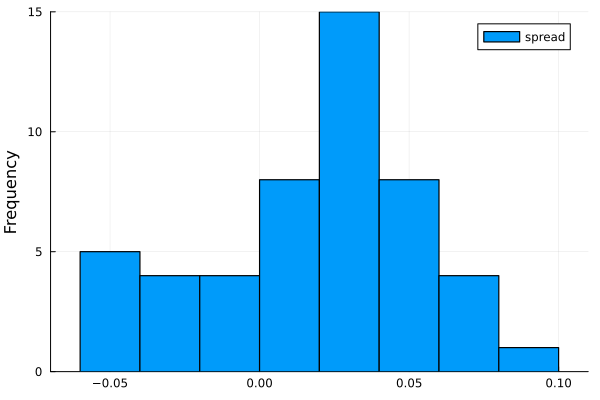

In [79]:
pollsUsElection2016 = dataset("dslabs", "polls_us_election_2016");
polls = filter(row -> row[:state] == "U.S." &&
                      row[:enddate] >= Date("2016-10-31") &&
                      (row[:grade] ∈ ["A+", "A", "A-", "B+"] || row[:grade] == "" ),
               pollsUsElection2016);
polls.spread = polls.rawpoll_clinton / 100 - polls.rawpoll_trump / 100;
polls.samplesize = map(n -> parse(Int, n), polls.samplesize)
N = sum(polls.samplesize)
d̂ = (polls.spread' * polls.samplesize) / N
p̂ = (d̂ + 1) / 2
α = 0.05
confidence = 1 - α / 2
μₑ = qnorm(confidence) * 2 * sqrt(p̂ * (1 - p̂) / N)
plotHistogram = histogram(polls.spread, bins=:auto, binwidth = 0.01, linecolor="black", linewidth=1.2,
                          label="spread", ylabel="Frequency")

In [80]:
groupby(polls, :pollster) |> g -> combine(g, nrow => :count)

Row,pollster,count
,String,Int64
1,ABC News/Washington Post,7
2,Ipsos,6
3,Fox News/Anderson Robbins Research/Shaw & Company Research,2
4,CBS News/New York Times,2
5,NBC News/Wall Street Journal,1
6,IBD/TIPP,8
7,Selzer & Company,1
8,Angus Reid Global,1
9,Monmouth University,1


In [93]:
groupby(polls, :pollster) |>
    # g -> combine(g, nrow => :count) |>
    g -> filter(row -> nrow(row) >= 6, g) |>
    combine |>
    df -> scatter(df.pollster, df.spread, xrotation=90, legend=false,
                  xlabel="Pollster", ylabel="Spread")

ArgumentError: ArgumentError: column name :spread not found in the data frame

In [104]:
groupby(polls, :pollster) |>
    g -> combine(g, nrow => :count) |>
    g -> filter(row -> row[:count] >= 6, g)
    g -> combine(polls, g)

#189 (generic function with 1 method)